__Students:__ Andrea Ceriati, Sarah Demmon, Kat McEldowney, Chantal Thomas 

__Instructor:__ Daniel Pulido-Mendez

__Institution:__ Columbia Engineering

__Course:__ Data Analytics Boot Camp

__Assignment:__ Python Project

__Date:__ 12/18/2023

# Python Project

## Table of Contents


   [**Introduction**](#Intro1)

   [**Importing Libraries**](#IL)

1. [**Data Import, Cleaning & Wrangling**](#DWrang)

    1.1 [**Importing Census Data**](#CensusD)
    
    1.2 [**Importing Tax Data**](#TaxD)

    1.3 [**Merge the Data**](#DataD)

    1.4 [**Handling Missing Data**](#MissD)

    1.5 [**Checking and Correcting Data Format**](#FormD)

2. [**Exploratory Data Analysis**](#EDA)

    2.1 [**Descriptive Statistics**](#DS)

    2.2 [**Correlation**](#Corr)

    2.3 [**Data Visualization**](#DV)

3. [**Conclusions**](#Concl)

## Introduction <a name="Intro1"></a>

New York imposes a mortgage tax on real estate transactions. In NYC, the tax rates are 1.8% for mortgages under $500,000 and 1.95% for mortgages over $500,000. No sales tax is applied when buying a home, but the mortgage amount is taxed. Sales tax (1%) is only applied to homes over $1,000,000.

- A $500,000 cash purchase incurs no tax.
- A 20% down payment ($400,000 mortgage) results in $7,200 in mortgage tax.
- A 3% down payment requires an additional $8,730 in closing costs.

**Project Hypotheses**

1. Impact on Economically Disadvantaged:

- Explore how this policy disproportionately affects economically disadvantaged individuals.

2. Revenue Impact of Tax Adjustment:

- Assess the potential revenue increase if the tax is based on the sales price, not the mortgage amount.

- Consider a lower, uniform sales tax rate and a reduced Mansion tax for homes over a million dollars.

**Data Analysis Plan:**

- Analyze sales data of 15,550 Brooklyn homes sold in 2022.
- Calculate current mortgage tax revenue.
- Project revenue under a 2/3 reduced sales tax rate.
- Assess impact of a 0.5% Mansion tax for high-value homes.

**Demographic Examination**

- Use census data to compare demographics across different zip codes.
- Explore whether lower-income individuals contribute a larger share of this tax compared to higher-income areas.

## Importing Libraries <a name="IL"></a>

In [1]:
import pandas as pd
import numpy as np
import requests
from census import Census
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
import plotly.express as px
from urllib.request import urlopen

import warnings
warnings.filterwarnings("ignore")

## 1. Data Cleaning & Wrangling <a name="DWrang"></a>

### 1.1 Importing Census Data <a name="CensusD"></a>

The dataset was obtained from the United States Census Bureau. To access the data, an API call was initiated. The dataset provides information on population, median age, household income, median gross rent, categorized by zipcode, for the year 2022.
The selected zip codes encompassed all of Brooklyn, including the four wealthiest and poorest zip codes in New York.

Information about the data and its variables can be found at links below:

* Review the following page to learn more about the Census API: <https://www.census.gov/programs-surveys/acs/technical-documentation/table-and-geography-changes/2022/5-year.html>

* Review the following page to learn more about the 2022 data labels: <https://api.census.gov/data/2022/acs/acs5/variables.html>

In [2]:
# Import U.S. Census API Key
from config import api_key

# Create an instance of the Census library
c = Census(
    api_key,
    year = 2022
)

# Run Census Search to retrieve data on all Brooklyn Zipcodes (2022 ACS5 Census)
census_data = c.acs5.get(
    (
        "NAME",
        "B19013_001E",
        "B01003_001E",
        "B01002_001E",
        "B25064_001E",
        "B25089_001E"
    ),
    {'for': 'zip code tabulation area:*'}
)

# Convert to DataFrame
census_df = pd.DataFrame(census_data)

# Column renaming
census_df = census_df.rename(
    columns = {
        "B01003_001E": "Population",
        "B01002_001E": "Median Age",
        "B19013_001E": "Household Income",
        "B25064_001E": "Median Gross Rent",
        "NAME": "Name",
        "zip code tabulation area": "Zipcode"
    }
)

# Configure the final DataFrame
census_df = census_df[
    [
        "Zipcode",
        "Population",
        "Median Age",
        "Household Income",
        "Median Gross Rent",
    ]
]

# Filter for just the considered zipcodes
zipcodes = ['11201', '11202', '11203', '11204','11205','11206','11207','11208',
'11209','11210','11211','11212','11213','11214','11215','11216','11217','11218',
'11219','11220','11221','11222','11223','11224','11225','11226','11228','11229',
'11230','11231','11232','11233','11234','11235','11236','11237','11238','11239',
'11240','11241','11242','11243','11247','11249','11252','11252','11256']

census_df=census_df.loc[census_df['Zipcode'].isin(zipcodes)]

### 1.2 Importing Tax Data <a name="TaxD"></a>

The property sales data was downloaded from Property Radar. The data was filtered to only included sales of condos and single family homes that closed in the 2022 calendar year and market sales that were listed on the open market. This means that the sample does not include short sales, forclosures, or arms length transactions (such as a preson selling to a family member or friend without first listing the home on the open market).
The dataset includes salses data of 15,550 homes sold in Brooklyn , NY in 2022, as well as 2,164 homes sold in 2022 of four of the highest income zip codes and the four lowest income zipcodes in the other boroughs.

In [3]:
# Import the data and create one dataset
full_df = pd.read_csv('Data/brooklyn_2022_sales.csv')

In [4]:
# Fill NaN values with 0
full_df = full_df.fillna(0)

# Rename 1st Amount Column. Add a count column
full_df.rename(columns={'1st Amount': 'Amount Mortgaged'}, inplace=True)
full_df['Count'] = 1 # Counter
full_df = full_df.loc[:, ['Count', 'ZIP', 'Type', 'Owner Occ?', 'Purchase Down %', 
                                 'Purchase Amt', 'Amount Mortgaged']]

In [5]:
# Calculate how much mortgage tax was collected.
# For mortgages less than $500,000, tax is 1.8% for mortgages of $500,000, 1.95% 
# Calculate the mansion tax as 1% for sales over $1,000,000
full_df['Mtg Tx Pd'] = np.where(full_df['Amount Mortgaged'] >= 500000, 
                                 full_df['Amount Mortgaged'] * 0.0195, full_df['Amount Mortgaged'] * 0.018)
full_df['Mansion Tax Pd'] = np.where(full_df['Purchase Amt'] >= 1000000, full_df['Purchase Amt'] * 0.01, 0)

In [6]:
# Created two dataframes, one for investor purchases and the other for primary residences
investor_df = full_df[(full_df['Owner Occ?'] ==1)]
owner_occ_df = full_df[(full_df['Owner Occ?'] == 0)]

In [7]:
# Calculate new sales tax info for private residences, 0.9% for purchases under $1mil and 
# Calculate new sales tax for investment purchases, 4.4357%
owner_occ_df['New Sales Tax Amount'] = np.where(owner_occ_df['Purchase Amt'] >= 1000000, owner_occ_df['Purchase Amt'] * 0.009,
                                owner_occ_df['Purchase Amt'] * 0.014)
investor_df['New Sales Tax Amount'] = investor_df['Purchase Amt'] * 0.04438

In [8]:
# Concatenated the two files
frames = [owner_occ_df, investor_df]
calculated_full_df = pd.concat(frames)
print(f"Number of rows and columns in the DataFrame: {calculated_full_df.shape}")

Number of rows and columns in the DataFrame: (3012, 10)


### 1.3 Merge the Data <a name="DataD"></a>

The two datasets were merged to form a unified dataframe for the final analysis.

In [9]:
# Rename ZIP column in calculated_full_df
calculated_full_df = calculated_full_df.rename(
    columns = {
        "ZIP": "Zipcode",
    }
)

# change datatype
census_df['Zipcode']=census_df['Zipcode'].astype('float64')

In [10]:
# Combine the data into a single DataFrame
complete_df = pd.merge(calculated_full_df, census_df, how="left", on=("Zipcode"))

In [11]:
# prints the size of the dataframe
print('The size of the data frame is:',complete_df.shape)

The size of the data frame is: (3012, 14)


### 1.4 Handling Missing Data <a name="MissD"></a>

The dataset was carefully examined to identify any missing data. During the analysis, it was noted that there were entries displaying a zipcode of 0, which is not valid for Brooklyn. Additionally, there was a zipcode, 11243, representing just one block in Brooklyn, for which no census data was available. This discovery is intriguing and necessitates further investigation.

In [12]:
# Verify if the data contains missing values
missing_data=complete_df.isnull()
for column in missing_data.columns:
    print(column)
    print(missing_data[column].value_counts()) 
    print("")

Count
Count
False    3012
Name: count, dtype: int64

Zipcode
Zipcode
False    3012
Name: count, dtype: int64

Type
Type
False    3012
Name: count, dtype: int64

Owner Occ?
Owner Occ?
False    3012
Name: count, dtype: int64

Purchase Down %
Purchase Down %
False    3012
Name: count, dtype: int64

Purchase Amt
Purchase Amt
False    3012
Name: count, dtype: int64

Amount Mortgaged
Amount Mortgaged
False    3012
Name: count, dtype: int64

Mtg Tx Pd
Mtg Tx Pd
False    3012
Name: count, dtype: int64

Mansion Tax Pd
Mansion Tax Pd
False    3012
Name: count, dtype: int64

New Sales Tax Amount
New Sales Tax Amount
False    3012
Name: count, dtype: int64

Population
Population
False    2997
True       15
Name: count, dtype: int64

Median Age
Median Age
False    2997
True       15
Name: count, dtype: int64

Household Income
Household Income
False    2997
True       15
Name: count, dtype: int64

Median Gross Rent
Median Gross Rent
False    2997
True       15
Name: count, dtype: int64



In [13]:
# Print rows with missing values
complete_df[complete_df.isnull().any(axis=1)]

,Count,Zipcode,Type,Owner Occ?,Purchase Down %,Purchase Amt,Amount Mortgaged,Mtg Tx Pd,Mansion Tax Pd,New Sales Tax Amount,Population,Median Age,Household Income,Median Gross Rent
583,1,11243,CND,0,100.0,1125000,0.0,0.000,11250.0,10125.000,NaN,NaN,NaN,NaN
584,1,11243,CND,0,81.0,995000,184239.0,3316.302,0.0,13930.000,NaN,NaN,NaN,NaN
585,1,11243,CND,0,95.0,14250000,750000.0,14625.000,142500.0,128250.000,NaN,NaN,NaN,NaN
586,1,11243,CND,0,21.0,1070000,848000.0,16536.000,10700.0,9630.000,NaN,NaN,NaN,NaN
587,1,11243,CND,0,20.0,1530000,1224000.0,23868.000,15300.0,13770.000,NaN,NaN,NaN,NaN
588,1,11243,CND,0,28.0,1699000,1220000.0,23790.000,16990.0,15291.000,NaN,NaN,NaN,NaN
589,1,11243,CND,0,100.0,1400000,0.0,0.000,14000.0,12600.000,NaN,NaN,NaN,NaN
590,1,11243,CND,0,60.0,1340000,535000.0,10432.500,13400.0,12060.000,NaN,NaN,NaN,NaN
591,1,11243,CND,0,100.0,3200000,0.0,0.000,32000.0,28800.000,NaN,NaN,NaN,NaN
1921,1,11243,CND,1,20.0,537500,430000.0,7740.000,0.0,23854.250,NaN,NaN,NaN,NaN


In [14]:
# Drop rows with Nan values
complete_df.drop(index=[583,584,585,586,587,588,589,590,591,
                        1921,1922,1923,1924,1925,1926], inplace=True)

In [15]:
# print number of missing data in the dataset
print('The number of missing data in the dataset is:',complete_df.isnull().sum().sum())

The number of missing data in the dataset is: 0


In [16]:
complete_df.shape

(2997, 14)

### 1.5 Checking and Correcting Data Format <a name="FormD"></a>

In [17]:
# Check datatypes
complete_df.dtypes

Count                     int64
Zipcode                   int64
Type                     object
Owner Occ?                int64
Purchase Down %         float64
Purchase Amt              int64
Amount Mortgaged        float64
Mtg Tx Pd               float64
Mansion Tax Pd          float64
New Sales Tax Amount    float64
Population              float64
Median Age              float64
Household Income        float64
Median Gross Rent       float64
dtype: object

In [18]:
# Change datatype for zipcode
complete_df['Zipcode']=complete_df['Zipcode'].astype('object')

In [19]:
# Reset indeces
complete_df.reset_index(drop=True, inplace=True)

In [20]:
complete_df.head()

,Count,Zipcode,Type,Owner Occ?,Purchase Down %,Purchase Amt,Amount Mortgaged,Mtg Tx Pd,Mansion Tax Pd,New Sales Tax Amount,Population,Median Age,Household Income,Median Gross Rent
0,1,11201,CND,0,33.0,4600000,3062500.0,59718.7500,46000.0,41400.0,69755.0,35.1,163310.0,3110.0
1,1,11201,CND,0,100.0,4740000,0.0,0.0000,47400.0,42660.0,69755.0,35.1,163310.0,3110.0
2,1,11201,CND,0,81.0,4200000,787743.0,15360.9885,42000.0,37800.0,69755.0,35.1,163310.0,3110.0
3,1,11201,CND,0,20.0,3700000,2960000.0,57720.0000,37000.0,33300.0,69755.0,35.1,163310.0,3110.0
4,1,11201,CND,0,71.0,1655000,478540.0,8613.7200,16550.0,14895.0,69755.0,35.1,163310.0,3110.0


In [21]:
# Export the City_Data into a csv
complete_df.to_csv("final.csv", encoding="utf-8", index=False)

## 2. Exploratory Data Analysis <a name="EDA"></a>

### 2.1 Descriptive Statistics <a name="DS"></a>

Summary statistics for the dataset were printed.

Knowing the summary statistics for the whole dataset gave a lot of information about each variable and set the basis for a good exploratory analysis.

In [22]:
complete_df.describe()

,Count,Owner Occ?,Purchase Down %,Purchase Amt,Amount Mortgaged,Mtg Tx Pd,Mansion Tax Pd,New Sales Tax Amount,Population,Median Age,Household Income,Median Gross Rent
count,2997.0,2997.000000,2997.000000,2.997000e+03,2.997000e+03,2997.000000,2997.000000,2997.000000,2997.000000,2997.000000,2997.000000,2997.000000
mean,1.0,0.472139,44.020020,1.214225e+06,6.375541e+05,12307.199369,7827.393230,30534.361356,71584.858859,37.628328,97640.814815,2021.971305
std,0.0,0.499306,33.341443,1.175700e+06,7.485164e+05,14638.764523,13841.097031,35348.060226,18264.745179,4.665048,37566.381597,532.018719
min,1.0,0.000000,0.000000,5.600000e+04,0.000000e+00,0.000000,0.000000,784.000000,16808.000000,25.800000,35840.000000,925.000000
25%,1.0,0.000000,20.000000,6.820000e+05,3.000000e+05,5400.000000,0.000000,11340.000000,58047.000000,35.100000,68006.000000,1627.000000
50%,1.0,0.000000,30.000000,9.100000e+05,5.600000e+05,10920.000000,0.000000,20880.000000,72014.000000,37.200000,88546.000000,1732.000000
75%,1.0,1.000000,70.000000,1.350000e+06,8.000000e+05,15600.000000,13500.000000,37723.000000,89976.000000,42.200000,125747.000000,2368.000000
max,1.0,1.000000,100.000000,3.056371e+07,1.806635e+07,352293.864000,305637.140000,763336.000000,108180.000000,49.400000,173899.000000,3110.000000


Looking at the summary statistics above it was possible to obtain information as the mean, median, standar deviation, min, max, percentiles, of the variables.

In [23]:
complete_df.describe(include=object)

,Zipcode,Type
count,2997,2997
unique,38,2
top,11234,CND
freq,292,1745


Summary statistics for object values provided information on the number of unique values in each category and which one is more frequent.
From the table above it could be noticed that the zip code with more sales was 11234, with a frequenxy of 1760. Also, the most common house type is condominium, with a frequency of 9951.

### 2.2 Correlation <a name="Corr"></a>

Since there were a lot of variables to take into account, correlation helped predict whether some variables had some predictive power over other variables. The correlation coefficient is a statistic that measures the degree to which a variable is a function of some other variable. This value ranges from -1 to 1.

The correlation coefficient between all the variables was calculated to gain a better understanding of which variables were dependent of which other ones.

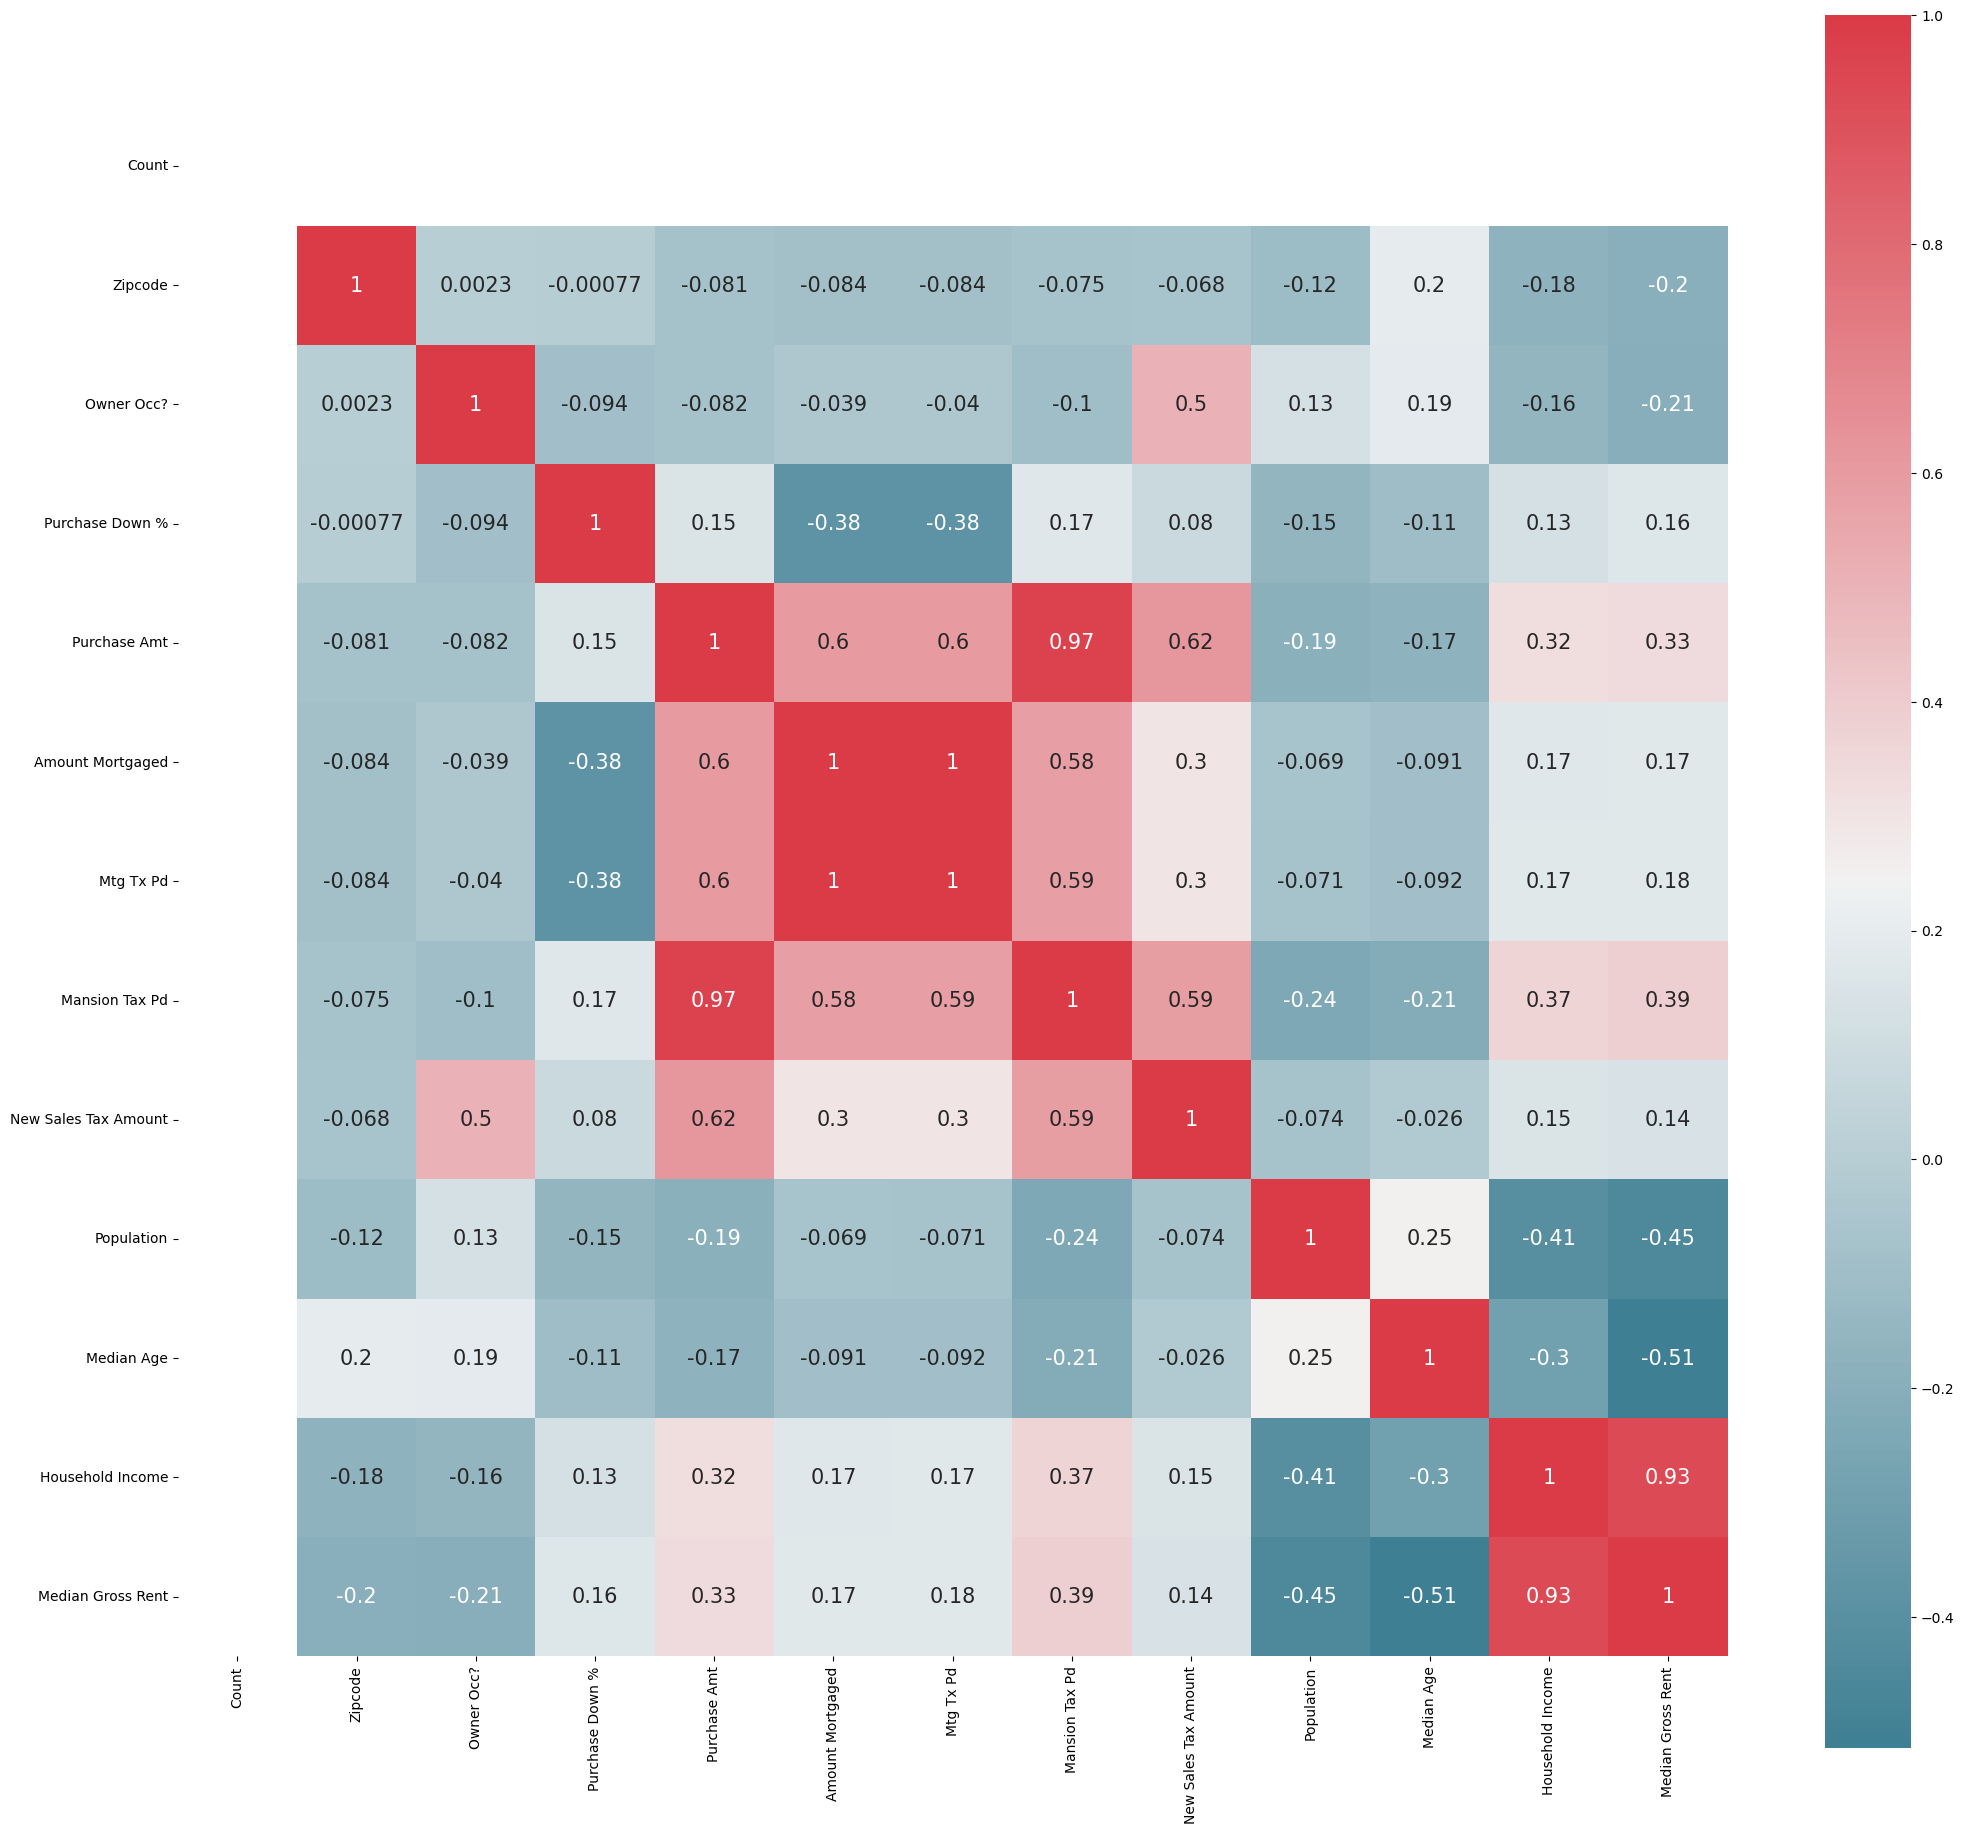

In [24]:
# Drop a certain column
corr_df = complete_df.drop(columns='Type') 

def plot_correlation_map(df):
    corr=df.corr()
    _,ax=plt.subplots(figsize=(25,25))
    cmap=sns.diverging_palette(220,10,as_cmap = True )
    _=sns.heatmap(corr,
        cmap=cmap,
        square=True,
        cbar_kws={'shrink':.9},
        ax=ax,
        annot=True,
        annot_kws={'fontsize':15})

plot_correlation_map(corr_df)

### 2.3 Data Visualization <a name="DV"></a>

To gain a better understanding of the correlations, the following code was utilized to create scatter plots between all the variables.
This allowed to better visualize which variables were related and and which relationship could have analyzed more closely.

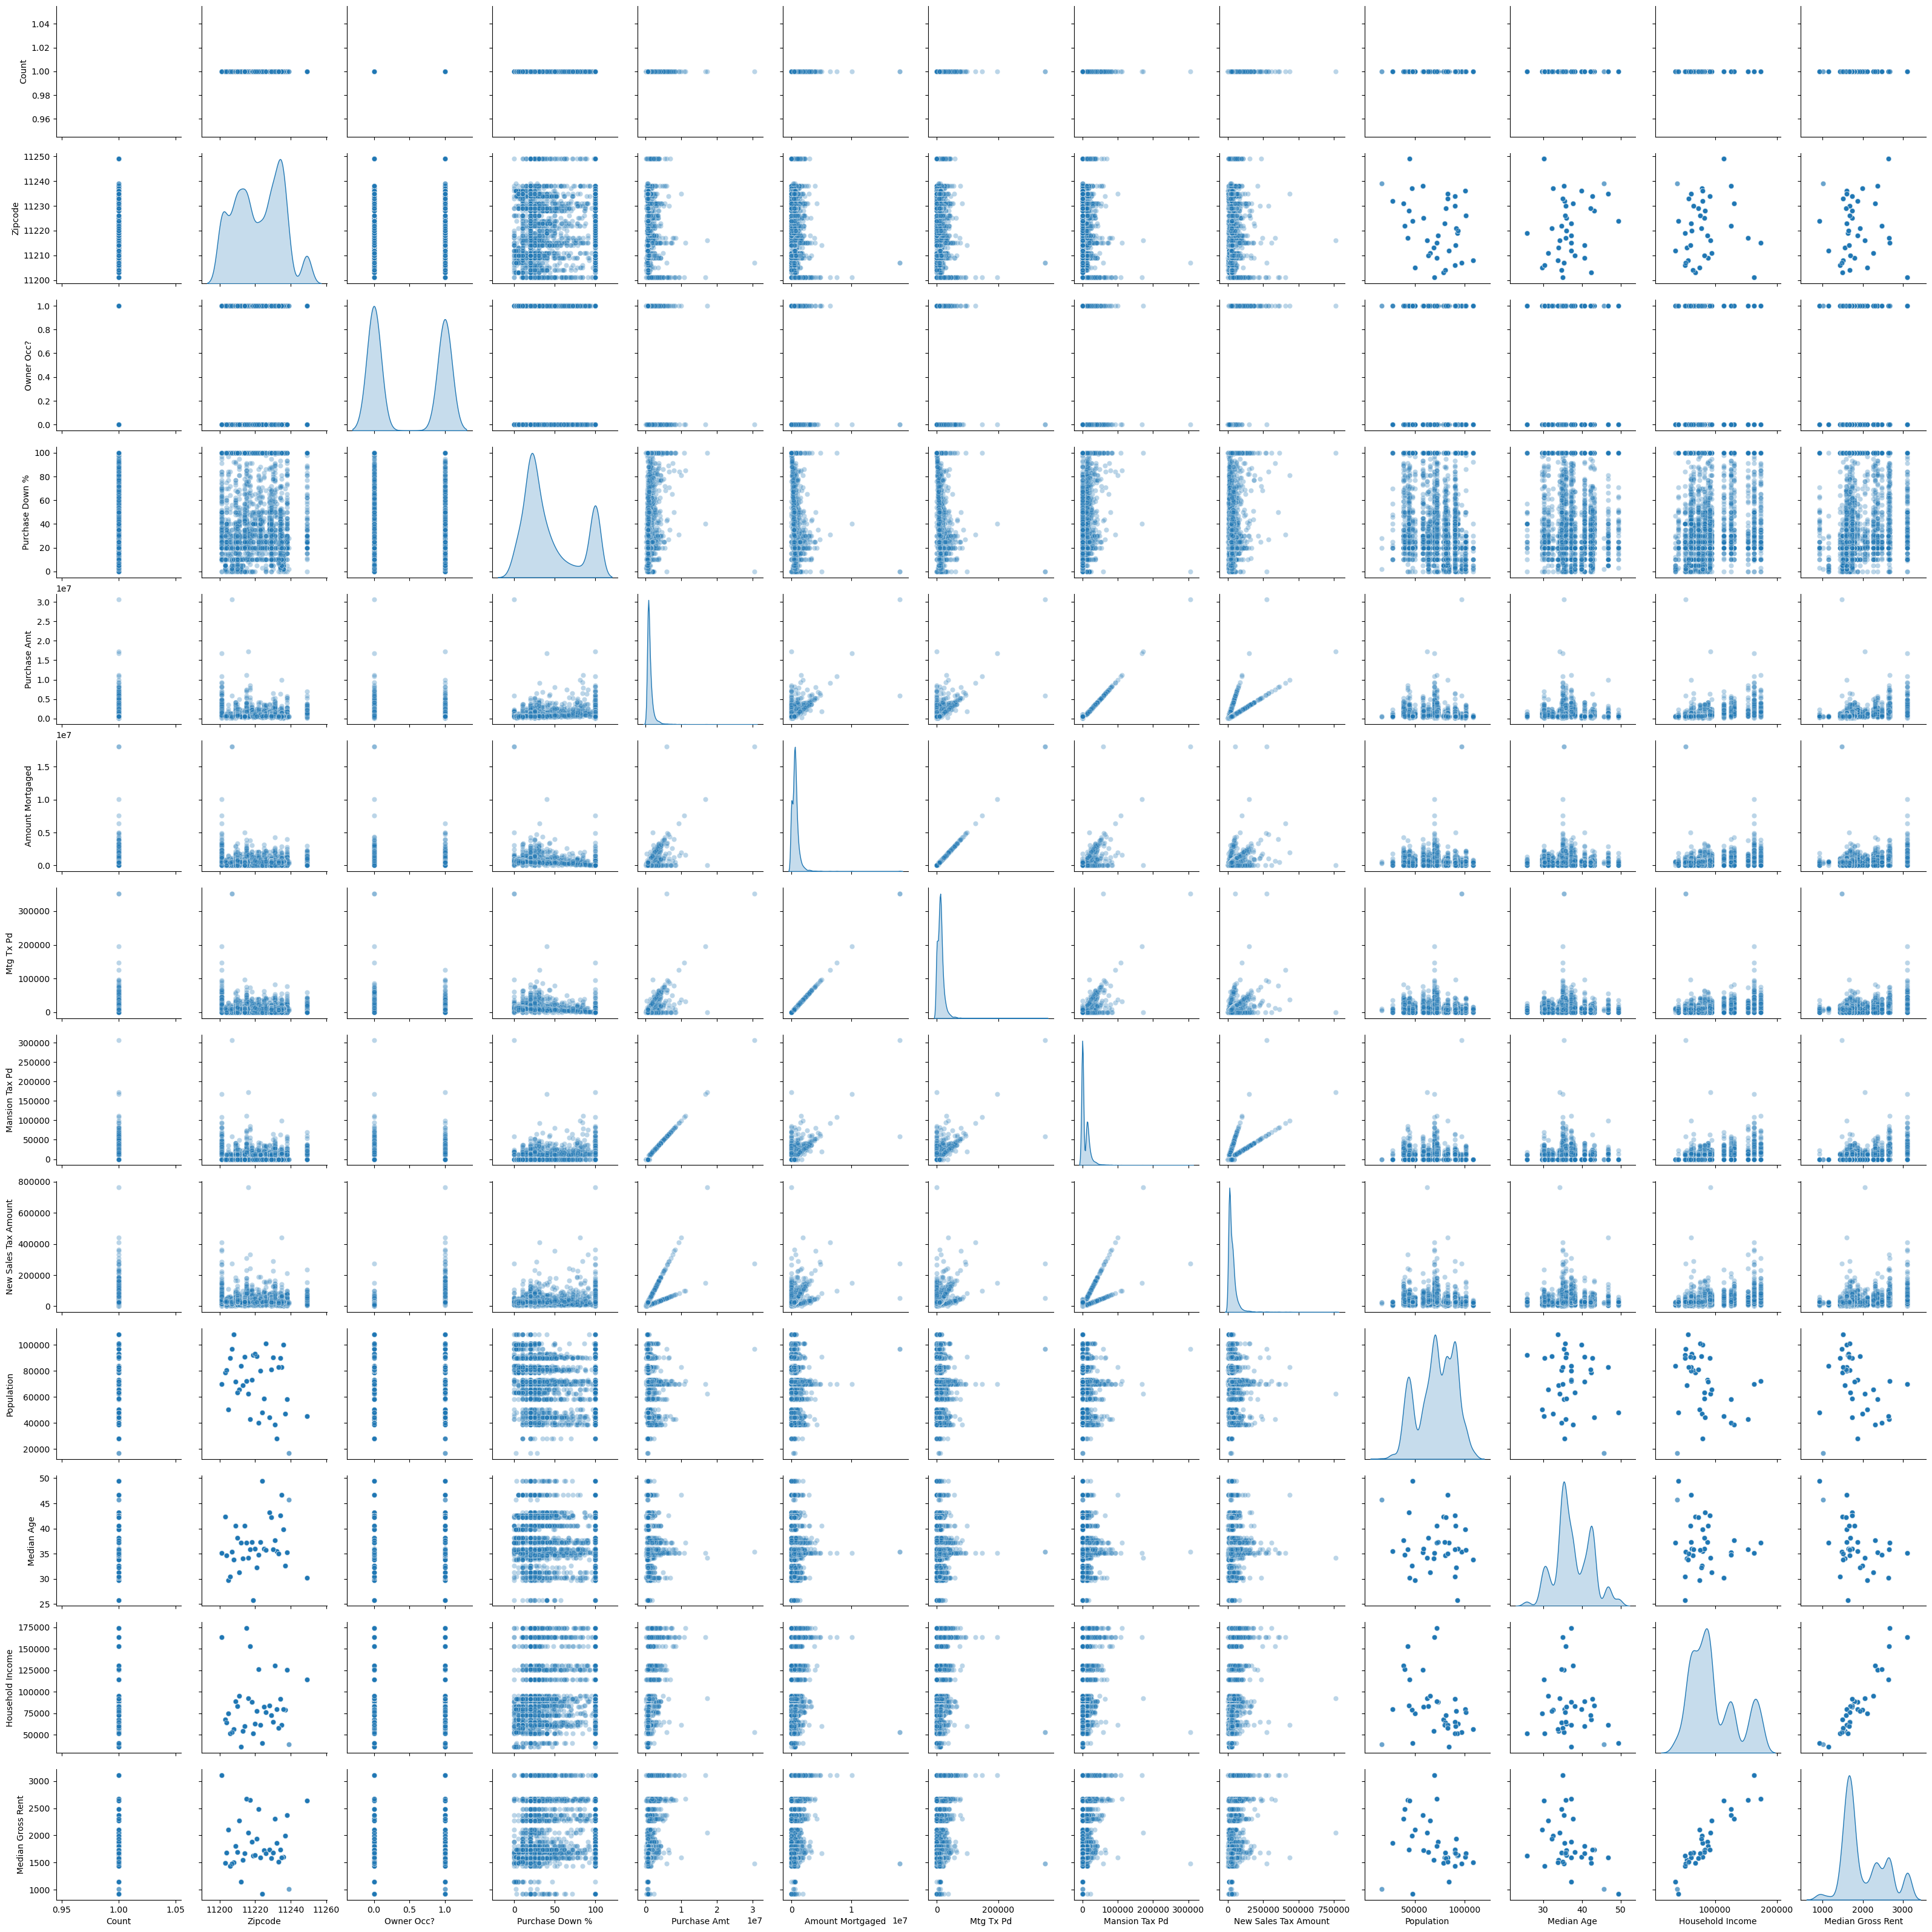

In [25]:
sns.pairplot(complete_df, plot_kws={'alpha': 0.3}, diag_kind = 'kde')


The data was employed to compute the total mortgage tax generated and to project the potential revenue under an alternative scenario involving a sales tax. In this hypothetical scenario, the sales tax was considered at half of the current mortgage tax rate, half of the existing mansion tax rate for primary residence purchases, and half of the prevailing sales tax rate for investment property acquisitions.


In [26]:
#show the total mortgage tax and mansion taxes collected and compare to what our hypothetical tax would have raised

total_mtg_tax_pd = owner_occ_df['Mtg Tx Pd'].sum()
total_mansion_tax_pd = owner_occ_df['Mansion Tax Pd'].sum()
total_est_tax = owner_occ_df['New Sales Tax Amount'].sum()
total_mtg_tax_inves_pd = investor_df['Mtg Tx Pd'].sum()
total_mansion_tax_inves_pd = investor_df['Mansion Tax Pd'].sum()
total_est_inves_tax = investor_df['New Sales Tax Amount'].sum()
print(f"The total mortgage tax paid in Brooklyn by individuals purchasing primary residences in 2022 was ${total_mtg_tax_pd:,.0f} and the total mansion tax collected was ${total_mansion_tax_pd:,.0f}.")
print(f'The combined mortgage and mansion tax was {total_mtg_tax_pd + total_mansion_tax_pd:,.0f}, our hypothetical sales tax would have raised ${total_est_tax:,.0f}')
print(f"The total mortgage tax paid in Brooklyn by investors in 2022 was ${total_mtg_tax_inves_pd:,.0f} and the total mansion tax collected was ${total_mansion_tax_inves_pd:,.0f}.")
print(f'The combined mortgage and mansion tax was {total_mtg_tax_inves_pd + total_mansion_tax_inves_pd:,.0f}, our hypothetical sales tax on investments would have raised ${total_est_inves_tax:,.0f}')
print(f'The total tax raised in 2022 was {total_mtg_tax_pd + total_mansion_tax_pd + total_mtg_tax_inves_pd + total_mansion_tax_inves_pd:,.0f} and the total amount that would have been raised would have been ${total_est_tax + total_est_inves_tax:,.0f}')

The total mortgage tax paid in Brooklyn by individuals purchasing primary residences in 2022 was $20,431,958 and the total mansion tax collected was $14,760,917.
The combined mortgage and mansion tax was 35,192,875, our hypothetical sales tax would have raised $21,902,851
The total mortgage tax paid in Brooklyn by investors in 2022 was $16,638,799 and the total mansion tax collected was $9,044,858.
The combined mortgage and mansion tax was 25,683,657, our hypothetical sales tax on investments would have raised $70,280,519
The total tax raised in 2022 was 60,876,531 and the total amount that would have been raised would have been $92,183,370


## 3. Conclusions <a name="Concl"></a>